In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

In [2]:
path = r"input_files/spotify_rawdata/*.csv"                      # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

countries_spotify_df = pd.read_csv(glob.glob(path)[0], header=0) # Sets up main dataframe with data from FIRST file
string = str(glob.glob(path)[0])                                 # in the folder.
country_name, = re.findall(r"/spotify_rawdata/(.*)_tracks", string) # This line extracts the name of the country  
countries_spotify_df[['Country']] = country_name                 # from the file name

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=0)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        country_name, = re.findall(r"/spotify_rawdata/(.*)_tracks", string)
        temp_df[['Country']] = country_name
        #print (country_name)
        countries_spotify_df = pd.concat([countries_spotify_df,  # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.       
                                                 

countries_spotify_df                                             

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID,Danceability,Energy,Valence,Stream %,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Country,yyyy-mm,Tempo,Tempo_Stream%
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327,0.001410,0.001097,0.000461,0.000447,Global,NaN,NaN,NaN
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913,0.000975,0.000741,0.000890,0.000467,Global,NaN,NaN,NaN
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388,0.000866,0.000718,0.000336,0.000467,Global,NaN,NaN,NaN
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,0.662,0.000703,0.000638,0.000465,0.000470,Global,NaN,NaN,NaN
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,7DnAm9FOTWE3cUvso43HhI,0.720,0.706,0.620,0.000692,0.000498,0.000429,0.000488,Global,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4745,196,"Tujhe Kitna Chahein Aur (Film Version) [From ""...",Jubin Nautiyal,272866,https://open.spotify.com/track/3lT4SlZVvqLhMei...,2020,12,3lT4SlZVvqLhMeiuBv7gHW,0.358,0.252,0.284,0.000252,0.000090,0.000072,0.000063,India,NaN,NaN,NaN
4746,197,Mera Bhai,DIVINE,272385,https://open.spotify.com/track/3v3FEONiwvufayP...,2020,12,3v3FEONiwvufayPNcWzHhc,0.663,0.810,0.464,0.000251,0.000167,0.000117,0.000204,India,NaN,NaN,NaN
4747,198,Fallin for You,Shrey Singhal,272266,https://open.spotify.com/track/3uOh60vBloFwAv1...,2020,12,1le5KVGTF1xWf2aUj7ruLy,0.644,0.834,0.593,0.000251,0.000162,0.000149,0.000210,India,NaN,NaN,NaN
4748,199,"Hey Idi Nenena (From ""Solo Brathuke So Better"")",Thaman S,271156,https://open.spotify.com/track/4GC2IwmYrlC12Yf...,2020,12,4GC2IwmYrlC12YfPfHPLQe,0.770,0.834,0.628,0.000250,0.000193,0.000157,0.000209,India,NaN,NaN,NaN


In [13]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

# Create a function to match labels to a the correlation r coefficients. This will come in handy later
def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

# Create a function to match labels to p-values. This will come in handy later
def p_label(p):
    if p <= .05 : return "significant"
    else: return "insignificant"
    
#Set up list of countries to iterate through in the plot below
countries_to_plot = ['Global', 'Brazil', 'Germany','India', 'Italy', 
                     'Mexico', 'New Zealand', 'Spain', 'United Kingdom', 
                     'United States']


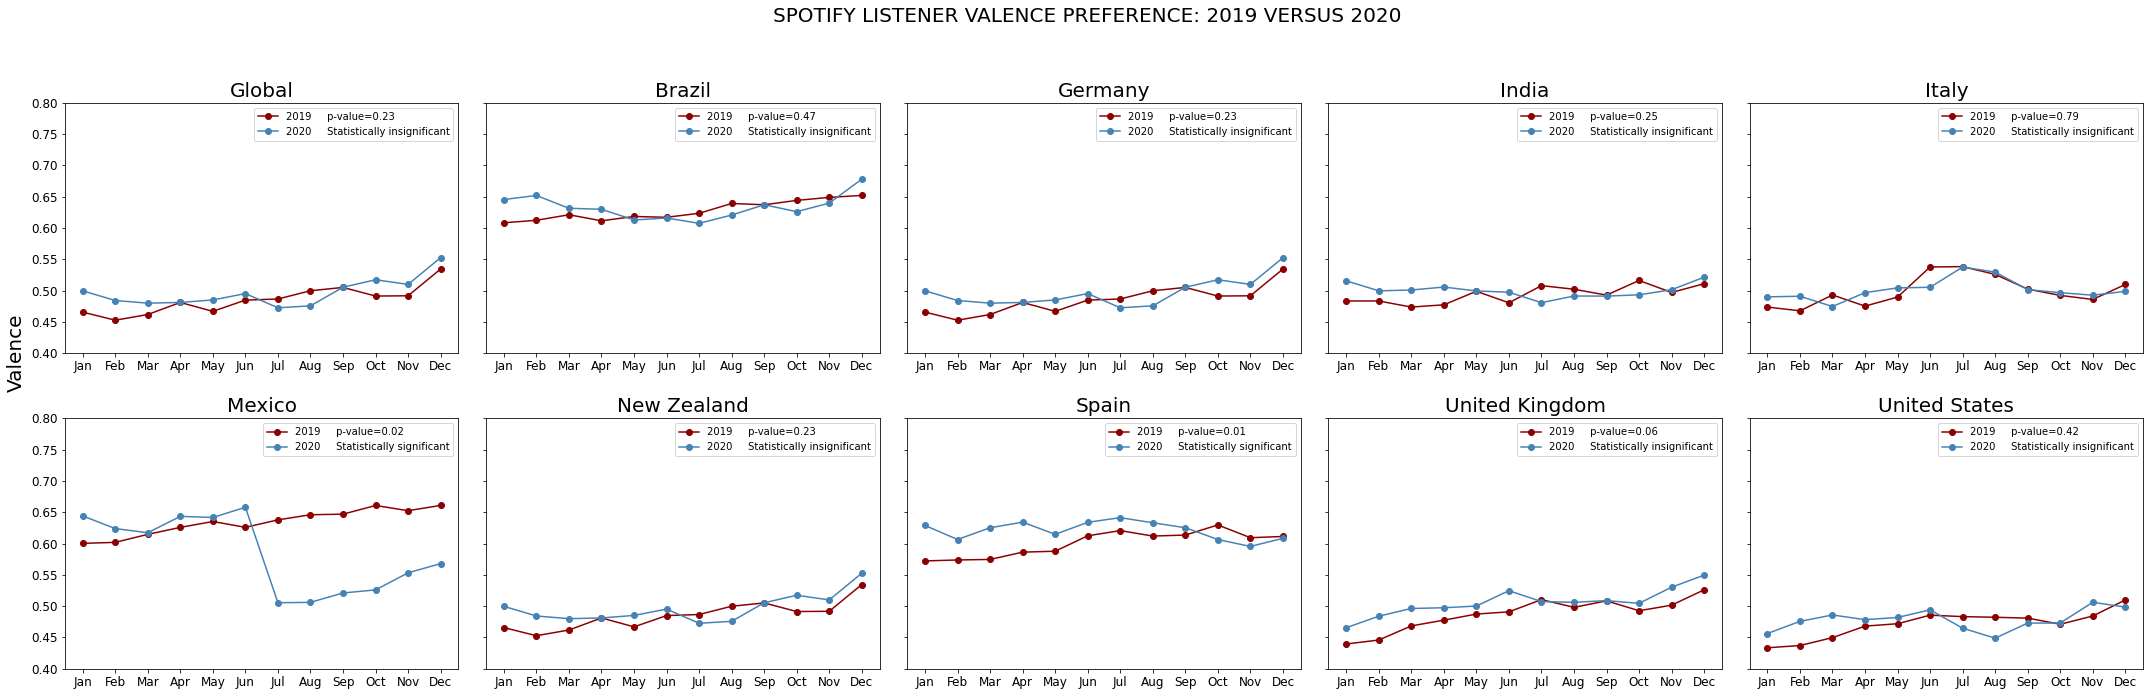

In [14]:
# Plot a comparison of 2019 and 2020 variable averages

variable_to_plot = 'Valence'                               # Establish the audio variable to plot

fig, ((ax0, ax1, ax2, ax3, ax4),                                # Set up figure for subplots
      (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2,5, sharey=True, figsize=(30,10))    

plot_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]  # Set up list of plots to help with the for loop below

plt.subplots_adjust(hspace=.3, wspace=0.05)                     # Formatting        

fig.suptitle(f"SPOTIFY LISTENER {variable_to_plot.upper()} PREFERENCE: 2019 VERSUS 2020\n",  size=20)     # Set title for the whole figure

fig.text(0, .5, f"{variable_to_plot}",                          # Set label for shared y axis 
         va='center', rotation='vertical', fontsize=20,         
         linespacing = 2)  


for i in range(10):                                             # Iterate through all though countries

    country_spotify_df = countries_spotify_df[countries_spotify_df['Country'] == countries_to_plot[i]]

    country_spotify_groupby = country_spotify_df.groupby(["Year", 'Month'], as_index=False)[variable_to_plot].mean()

    variable_2019 = country_spotify_groupby[country_spotify_groupby['Year'] == 2019]   # Set up 2019 to plot

    variable_2020 = country_spotify_groupby[country_spotify_groupby['Year'] == 2020]   # Set up 2020 to plot
            
    pvalue = stats.ttest_ind(variable_2019[f'{variable_to_plot}'],    # Run a t-test
                             variable_2020[f'{variable_to_plot}'], 
                             equal_var=False)[1]
    plabel = p_label(pvalue)                                  # Call function to create a label for the p value
    
    x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',               # Set up x axis
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  
    
    y_axis = variable_2019[variable_to_plot]                          # Set up y axis          

    plot_list[i].set_title(f"{countries_to_plot[i]}")                 # Set title for subplot

    plot_list[i].plot(x_axis, variable_2019[variable_to_plot],        # Plot 2019, 
                      label=f"2019     p-value={round(pvalue, 2)}",   # including the p-value in the label
                      marker='o', color='darkred')  
    
    plot_list[i].plot(x_axis, variable_2020[variable_to_plot],        # Plot 2020
                      label=f"2020     Statistically {plabel}",       # including the p-value in the label
                      marker='o', color='steelblue')  


    plot_list[i].set_ylim([.4, .8])                                   # Narrow y-axis limits

    plot_list[i].legend(fontsize=10)                                  # Add the legend

fig.tight_layout(pad=2)                                               # Tighten formatting

plt.savefig(f"output_files/{variable_to_plot}.png", transparent=False)                   # Export the png file   

plt.show()
    



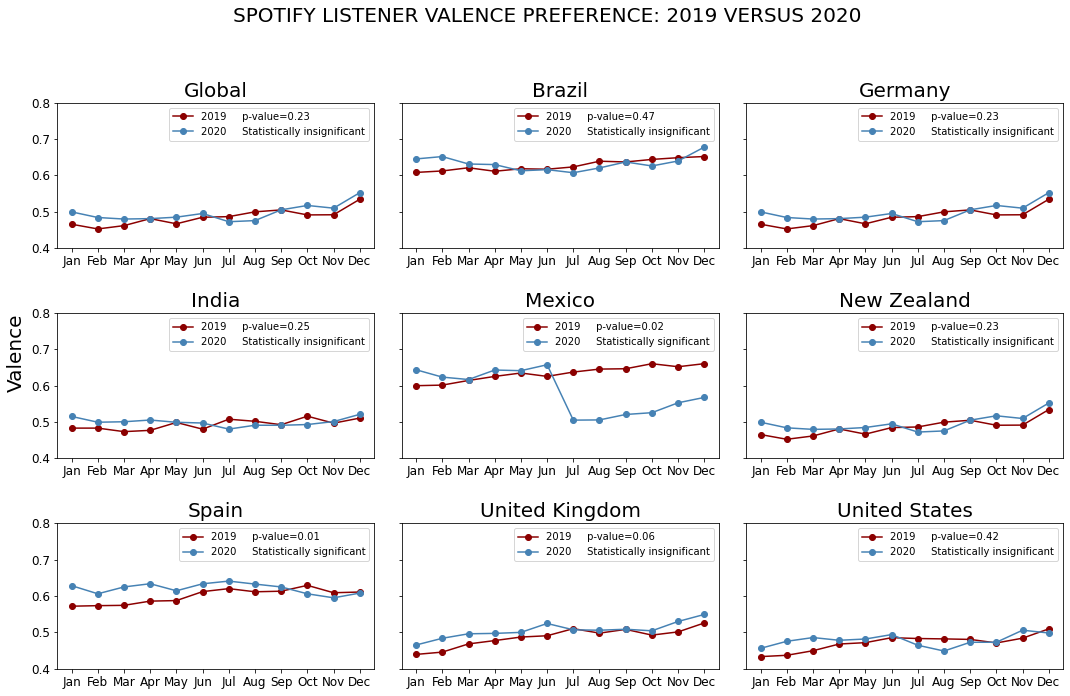

In [18]:
# Plot a comparison of 2019 and 2020 variable averages

countries_to_plot2 = ['Global', 'Brazil', 'Germany','India',
                     'Mexico', 'New Zealand', 'Spain', 'United Kingdom', 
                     'United States']

variable_to_plot = 'Valence'                               # Establish the audio variable to plot

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5),                                # Set up figure for subplots
      (ax6, ax7, ax8)) = plt.subplots(3,3, sharey=True, figsize=(15,10))    

plot_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]  # Set up list of plots to help with the for loop below

plt.subplots_adjust(hspace=.3, wspace=0.05)                     # Formatting        

fig.suptitle(f"SPOTIFY LISTENER {variable_to_plot.upper()} PREFERENCE: 2019 VERSUS 2020\n",  size=20)     # Set title for the whole figure

fig.text(0, .5, f"{variable_to_plot}",                          # Set label for shared y axis 
         va='center', rotation='vertical', fontsize=20,         
         linespacing = 2)  


for i in range(9):                                             # Iterate through all though countries

    country_spotify_df = countries_spotify_df[countries_spotify_df['Country'] == countries_to_plot2[i]]

    country_spotify_groupby = country_spotify_df.groupby(["Year", 'Month'], as_index=False)[variable_to_plot].mean()

    variable_2019 = country_spotify_groupby[country_spotify_groupby['Year'] == 2019]   # Set up 2019 to plot

    variable_2020 = country_spotify_groupby[country_spotify_groupby['Year'] == 2020]   # Set up 2020 to plot
            
    pvalue = stats.ttest_ind(variable_2019[f'{variable_to_plot}'],    # Run a t-test
                             variable_2020[f'{variable_to_plot}'], 
                             equal_var=False)[1]
    plabel = p_label(pvalue)                                  # Call function to create a label for the p value
    
    x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',               # Set up x axis
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  
    
    y_axis = variable_2019[variable_to_plot]                          # Set up y axis          

    plot_list[i].set_title(f"{countries_to_plot2[i]}")                 # Set title for subplot

    plot_list[i].plot(x_axis, variable_2019[variable_to_plot],        # Plot 2019, 
                      label=f"2019     p-value={round(pvalue, 2)}",   # including the p-value in the label
                      marker='o', color='darkred')  
    
    plot_list[i].plot(x_axis, variable_2020[variable_to_plot],        # Plot 2020
                      label=f"2020     Statistically {plabel}",       # including the p-value in the label
                      marker='o', color='steelblue')  


    plot_list[i].set_ylim([.4, .8])                                   # Narrow y-axis limits

    plot_list[i].legend(fontsize=10)                                  # Add the legend

fig.tight_layout(pad=2)                                               # Tighten formatting

plt.savefig(f"output_files/{variable_to_plot}3x3.png", transparent=False)                   # Export the png file   

plt.show()
    

In [19]:
# Import covid data

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # Read the covid data file

covid_df2 = covid_df.replace('World', 'Global')

covid_df2.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [20]:
# Filter covid data for only the countries we want to plot

countries_covid_df = covid_df2.loc[covid_df2['location'].isin(countries_to_plot)]  # Filter for countries we want to plot

countries_covid_df.to_csv("input_files/filtered_covid_data.csv")                   # Export the data to csv as backup

countries_covid_df[['Year']] = ''                                                  # Add Year and Month columns
countries_covid_df[['Month']] = ''                                                 # to fill in below

countries_covid_df.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
<ipython-input-20-b53f3edee7a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_covid_df[['Year']] = ''                                                  # Add Year and Month columns
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Year,Month
10813,BRA,South America,Brazil,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,,
10814,BRA,South America,Brazil,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,,
10815,BRA,South America,Brazil,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,,
10816,BRA,South America,Brazil,2020-02-29,2.0,1.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,,
10817,BRA,South America,Brazil,2020-03-01,2.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,,


In [21]:
# Add Year and Month to data in order to groupby later

for index, row in countries_covid_df.iterrows():
    
    try:
        countries_covid_df.at[index, 'Year'] = int(row['date'].split('-')[0])    # Extracts year and month from the
        countries_covid_df.at[index, 'Month'] = int(row['date'].split('-')[1])   # 'date' column, populates Year and
    except:                                                                      # month columns
        countries_covid_df.at[index, 'Year'] = np.nan
        countries_covid_df.at[index, 'Month'] = np.nan

countries_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Year,Month
10813,BRA,South America,Brazil,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10814,BRA,South America,Brazil,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10815,BRA,South America,Brazil,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10816,BRA,South America,Brazil,2020-02-29,2.0,1.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10817,BRA,South America,Brazil,2020-03-01,2.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,3


In [22]:
# Filter for 2020 data only

countries_covid_2020_df = countries_covid_df[countries_covid_df['Year'] == 2020]

countries_covid_2020_df = countries_covid_2020_df.rename(columns={"new_cases": "New Cases",      # Clean up some 
                                                                  'new_deaths' : "New Deaths"})  # formatting
countries_covid_2020_df.head()


,iso_code,continent,location,date,total_cases,New Cases,new_cases_smoothed,total_deaths,New Deaths,new_deaths_smoothed,...,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Year,Month
10813,BRA,South America,Brazil,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10814,BRA,South America,Brazil,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10815,BRA,South America,Brazil,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10816,BRA,South America,Brazil,2020-02-29,2.0,1.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,2
10817,BRA,South America,Brazil,2020-03-01,2.0,0.0,NaN,NaN,NaN,NaN,...,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,2020,3


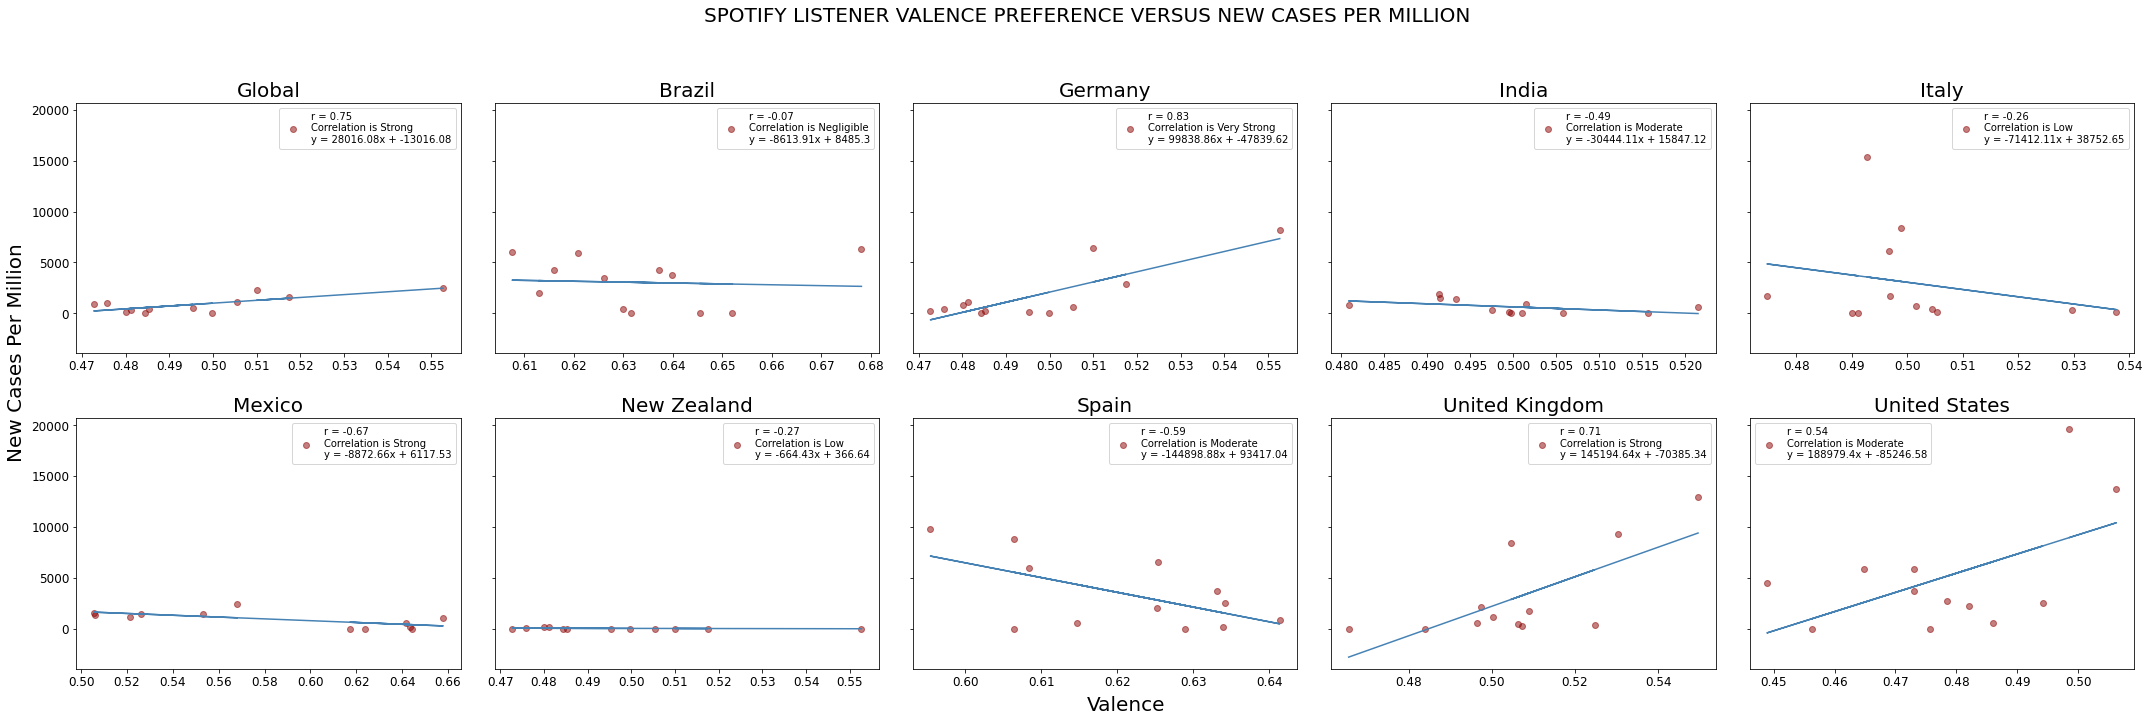

In [43]:
# Scatter plot comparison of 2020 data and covid variables

country_populations = [7674000000, 211000000, 84000000,          # These are needed to make 'per million'
                       1366000000, 60000000, 127000000,          # calculations below
                       4917000, 47000000, 66650000, 328000000]


# CHANGE VARIABLE NAME TO PLOT HERE                             # Choose the spotify and covid variables to plot.
# ---------------------------------                             # There are 3 Spotify variables (Valence,
spotify_variable_to_plot = 'Valence'                            # Danceability, & Energy) and 2 Covid variables   
covid_variable_to_plot = 'New Cases Per Million'                # (New Cases Per Million or New Deaths Per Million)
# ---------------------------------                             # that can be plotted automatically.   
                                                                      
fig, ((ax0, ax1, ax2, ax3, ax4),                                 # Set up figure for subplots
      (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2,5, sharey=True, figsize=(30,10))    

plot_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]   # Set up list of plots to help with the for loop below

plt.subplots_adjust(hspace=.3, wspace=0.05)                      # Formatting        

fig.suptitle(f"SPOTIFY LISTENER {spotify_variable_to_plot.upper()} PREFERENCE VERSUS {covid_variable_to_plot.upper()}\n",  size=20)     # Set title for the whole figure

fig.text(0, .5, f"{covid_variable_to_plot}",                     # Set label for shared y axis.
         va='center', rotation='vertical', fontsize=20,
         linespacing = 2)  

fig.text(.5, 0.01, f"{spotify_variable_to_plot}",                           # Set label for shared y axis.
         va='center', rotation='horizontal', fontsize=20,      
         linespacing = 2) 

   
for i in range(10):

    #ORGANIZING SPOTIFY DATA
    country_spotify_df = countries_spotify_df[countries_spotify_df['Country'] == countries_to_plot[i]]

    country_spotify_groupby = country_spotify_df.groupby(["Year", 'Month'], as_index=False)[spotify_variable_to_plot].mean()


    variable_2020 = country_spotify_groupby[country_spotify_groupby['Year'] == 2020]
    
    #ORGANIZING COVID DATA
    country_covid_df = countries_covid_2020_df[countries_covid_2020_df['location'] == countries_to_plot[i]]

    country_covid_groupby = country_covid_df.groupby(['Month'], as_index=False)[['New Cases', 'New Deaths']].sum()

    if len(country_covid_groupby) == 11:                 # Some countries have no data for January, leaving only
                                                         # 11 months of data

        country_covid_groupby.loc[-1] = [1, 0, 0]        # This adds a 1 (month of January) in the first column 
                                                         # index 0), in the last row of the dataframe. 
            
        country_covid_groupby.index = country_covid_groupby.index + 1   # shifts the index
    
    country_covid_groupby = country_covid_groupby.sort_index()      # sorts by index


    #MERGING SPOTIFY WITH COVID DATA INTO ONE NICE DATAFRAME TO PLOT
    country_covid_vs_spotify_df= pd.merge(variable_2020, country_covid_groupby, on="Month")

    country_covid_vs_spotify_df['New Cases Per Million'] = country_covid_vs_spotify_df['New Cases'] / country_populations[i] *1000000
    country_covid_vs_spotify_df['New Deaths Per Million'] = country_covid_vs_spotify_df['New Deaths'] / country_populations[i] *1000000
    
    #PLOTTING
    x_axis = country_covid_vs_spotify_df[spotify_variable_to_plot]      # Set up x axis
    y_axis = country_covid_vs_spotify_df[covid_variable_to_plot]        # Set up y axis

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
    regress_values = x_axis * slope + intercept                                  # Calculate regression values               

    r = round(stats.pearsonr(x_axis, y_axis)[0],2)                      # Calculate correlation coefficient
    rlabel = r_label(r)                                                 # Call function to create a label for the r number

    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Set up ression formula

    plot_list[i].scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
    label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

    plot_list[i].plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

    plot_list[i].set_title(f"{countries_to_plot[i]}")                   # Set title for subplot  
    
    plot_list[i].legend(fontsize=10)                                    # Add the legend

fig.tight_layout(pad=2)                                                 # Tighten formatting


plt.savefig(f"output_files/scatter_{spotify_variable_to_plot}_to_{covid_variable_to_plot}.png") # Export the png file   

plt.show()



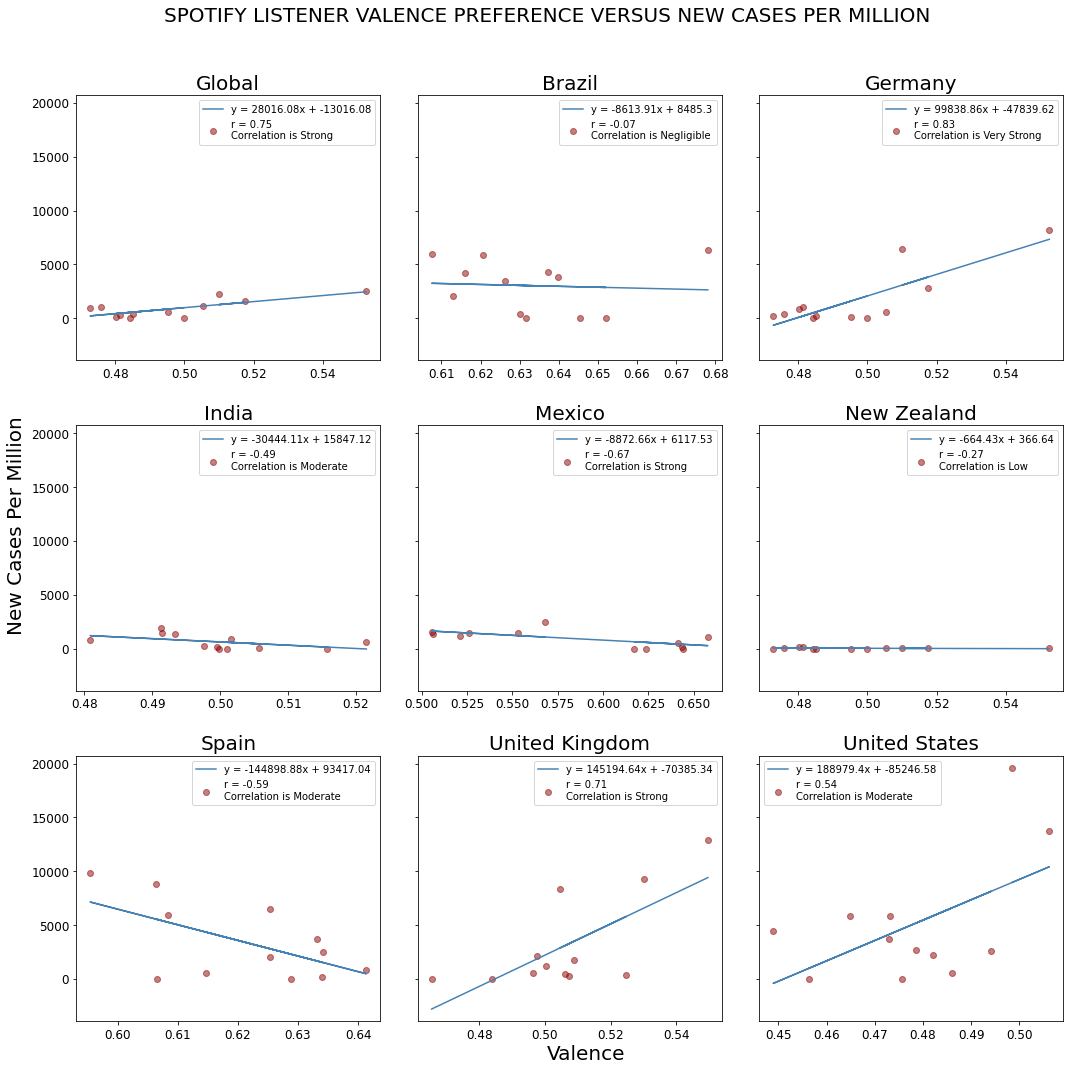

In [54]:
# Scatter plot comparison of 2020 data and covid variables

countries_to_plot2 = ['Global', 'Brazil', 'Germany','India',
                     'Mexico', 'New Zealand', 'Spain', 'United Kingdom', 
                     'United States']

country_populations = [7674000000, 211000000, 84000000,          # These are needed to make 'per million'
                       1366000000, 127000000,                    # calculations below
                       4917000, 47000000, 66650000, 328000000]


# CHANGE VARIABLE NAME TO PLOT HERE                             # Choose the spotify and covid variables to plot.
# ---------------------------------                             # There are 3 Spotify variables (Valence,
spotify_variable_to_plot = 'Valence'                            # Danceability, & Energy) and 2 Covid variables   
covid_variable_to_plot = 'New Cases Per Million'                # (New Cases Per Million or New Deaths Per Million)
# ---------------------------------                             # that can be plotted automatically.   
                                                                      
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5),                          # Set up figure for subplots
      (ax6, ax7, ax8)) = plt.subplots(3,3, sharey=True, figsize=(15,15))    

plot_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]   # Set up list of plots to help with the for loop below

plt.subplots_adjust(hspace=.3, wspace=0.05)                      # Formatting        

fig.suptitle(f"SPOTIFY LISTENER {spotify_variable_to_plot.upper()} PREFERENCE VERSUS {covid_variable_to_plot.upper()}\n",  size=20)     # Set title for the whole figure

fig.text(0, .5, f"{covid_variable_to_plot}",                     # Set label for shared y axis.
         va='center', rotation='vertical', fontsize=20,
         linespacing = 2)  

fig.text(.5, 0.01, f"{spotify_variable_to_plot}",                           # Set label for shared y axis.
         va='center', rotation='horizontal', fontsize=20,      
         linespacing = 2) 

   
for i in range(9):

    #ORGANIZING SPOTIFY DATA
    country_spotify_df = countries_spotify_df[countries_spotify_df['Country'] == countries_to_plot2[i]]

    country_spotify_groupby = country_spotify_df.groupby(["Year", 'Month'], as_index=False)[spotify_variable_to_plot].mean()


    variable_2020 = country_spotify_groupby[country_spotify_groupby['Year'] == 2020]
    
    #ORGANIZING COVID DATA
    country_covid_df = countries_covid_2020_df[countries_covid_2020_df['location'] == countries_to_plot2[i]]

    country_covid_groupby = country_covid_df.groupby(['Month'], as_index=False)[['New Cases', 'New Deaths']].sum()

    if len(country_covid_groupby) == 11:                 # Some countries have no data for January, leaving only
                                                         # 11 months of data

        country_covid_groupby.loc[-1] = [1, 0, 0]        # This adds a 1 (month of January) in the first column 
                                                         # index 0), in the last row of the dataframe. 
            
        country_covid_groupby.index = country_covid_groupby.index + 1   # shifts the index
    
    country_covid_groupby = country_covid_groupby.sort_index()      # sorts by index


    #MERGING SPOTIFY WITH COVID DATA INTO ONE NICE DATAFRAME TO PLOT
    country_covid_vs_spotify_df= pd.merge(variable_2020, country_covid_groupby, on="Month")

    country_covid_vs_spotify_df['New Cases Per Million'] = country_covid_vs_spotify_df['New Cases'] / country_populations[i] *1000000
    country_covid_vs_spotify_df['New Deaths Per Million'] = country_covid_vs_spotify_df['New Deaths'] / country_populations[i] *1000000
    
    #PLOTTING
    x_axis = country_covid_vs_spotify_df[spotify_variable_to_plot]      # Set up x axis
    y_axis = country_covid_vs_spotify_df[covid_variable_to_plot]        # Set up y axis

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
    regress_values = x_axis * slope + intercept                                  # Calculate regression values               

    r = round(stats.pearsonr(x_axis, y_axis)[0],2)                      # Calculate correlation coefficient
    rlabel = r_label(r)                                                 # Call function to create a label for the r number

    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Set up ression formula

    plot_list[i].plot(x_axis, regress_values, color="steelblue", label=f"{line_eq}" )                 # Plot the regression line    

    plot_list[i].scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
    label=f"r = {r}\nCorrelation is {rlabel}" ) 

    plot_list[i].set_title(f"{countries_to_plot2[i]}")                   # Set title for subplot  
    
    plot_list[i].legend(fontsize=10)                                    # Add the legend

fig.tight_layout(pad=2)                                                 # Tighten formatting


plt.savefig(f"output_files/scatter_{spotify_variable_to_plot}_to_{covid_variable_to_plot}3x3.png") # Export the png file   

plt.show()

